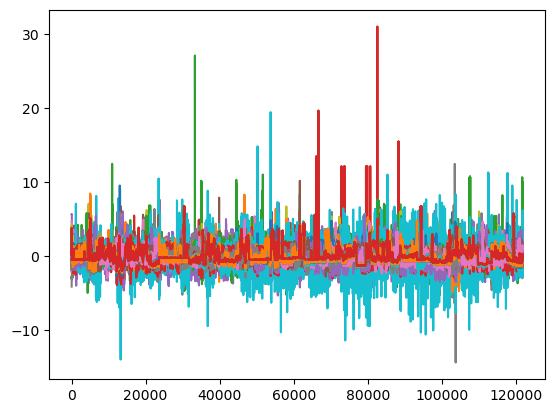

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, zscore, mode
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

SUBJECT_LIST = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,17]
NUM_SUBJECTS = len(SUBJECT_LIST)

def load_dict_from_pickle(file_path):
    try:
        # Open the file in binary read mode
        with open(file_path, 'rb') as f:
            # Load the dictionary from the file
            loaded_dict = pickle.load(f)
        #print("Dictionary loaded from pickle file:", file_path)
        return loaded_dict
    except Exception as e:
        print("Error:", e)
        print("Failed to load dictionary from pickle file.")
    return None

# Load the 3 possible dicts (different scaling)
# After some analysis of tradeoffs, I am choosing to move forward using features z scored by subject.

# This is z scored by subject. I'm cutting that part out of the name for simplicity. 
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

plt.plot(feature_dict['features'])
#plt.ylim([-10, 10])
#plt.xlim([0, 2000])
plt.show()
# file_path = f"features/combined/feature_dict.pkl"
# file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
# file_path_zscored = f"features/combined/feature_dict_zscored.pkl"

# feature_dict = load_dict_from_pickle(file_path)
# feature_dict_zscored_by_sub = load_dict_from_pickle(file_path_zscored_by_sub)
# feature_dict_zscored = load_dict_from_pickle(file_path_zscored)

In [7]:
def remove_features(feature_dict, features_to_remove):
    # Get indices of features to remove
    remove_feature_indices = np.where(np.isin(feature_dict['feature_names'], features_to_remove))
    
    # Remove them
    features = np.delete(feature_dict['features'], remove_feature_indices, axis=1)
    feature_names = np.delete(feature_dict['feature_names'], remove_feature_indices)
    
    # Create a new dict with the features removed
    new_feature_dict = {'features': features, 'feature_names': feature_names, 'labels': feature_dict['labels'], 'subject': feature_dict['subject']}
    return new_feature_dict

### First, let's take a look at correlations between feature

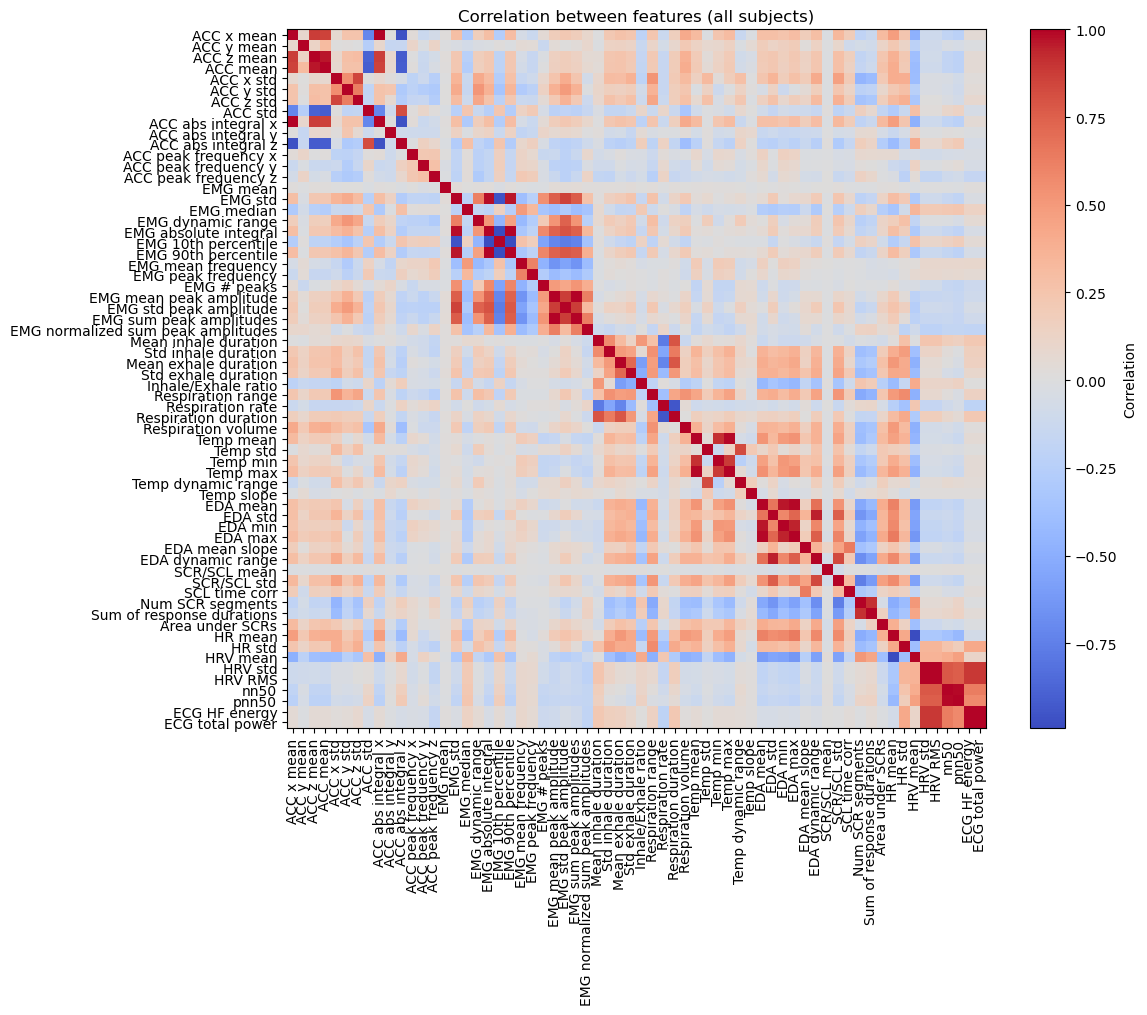

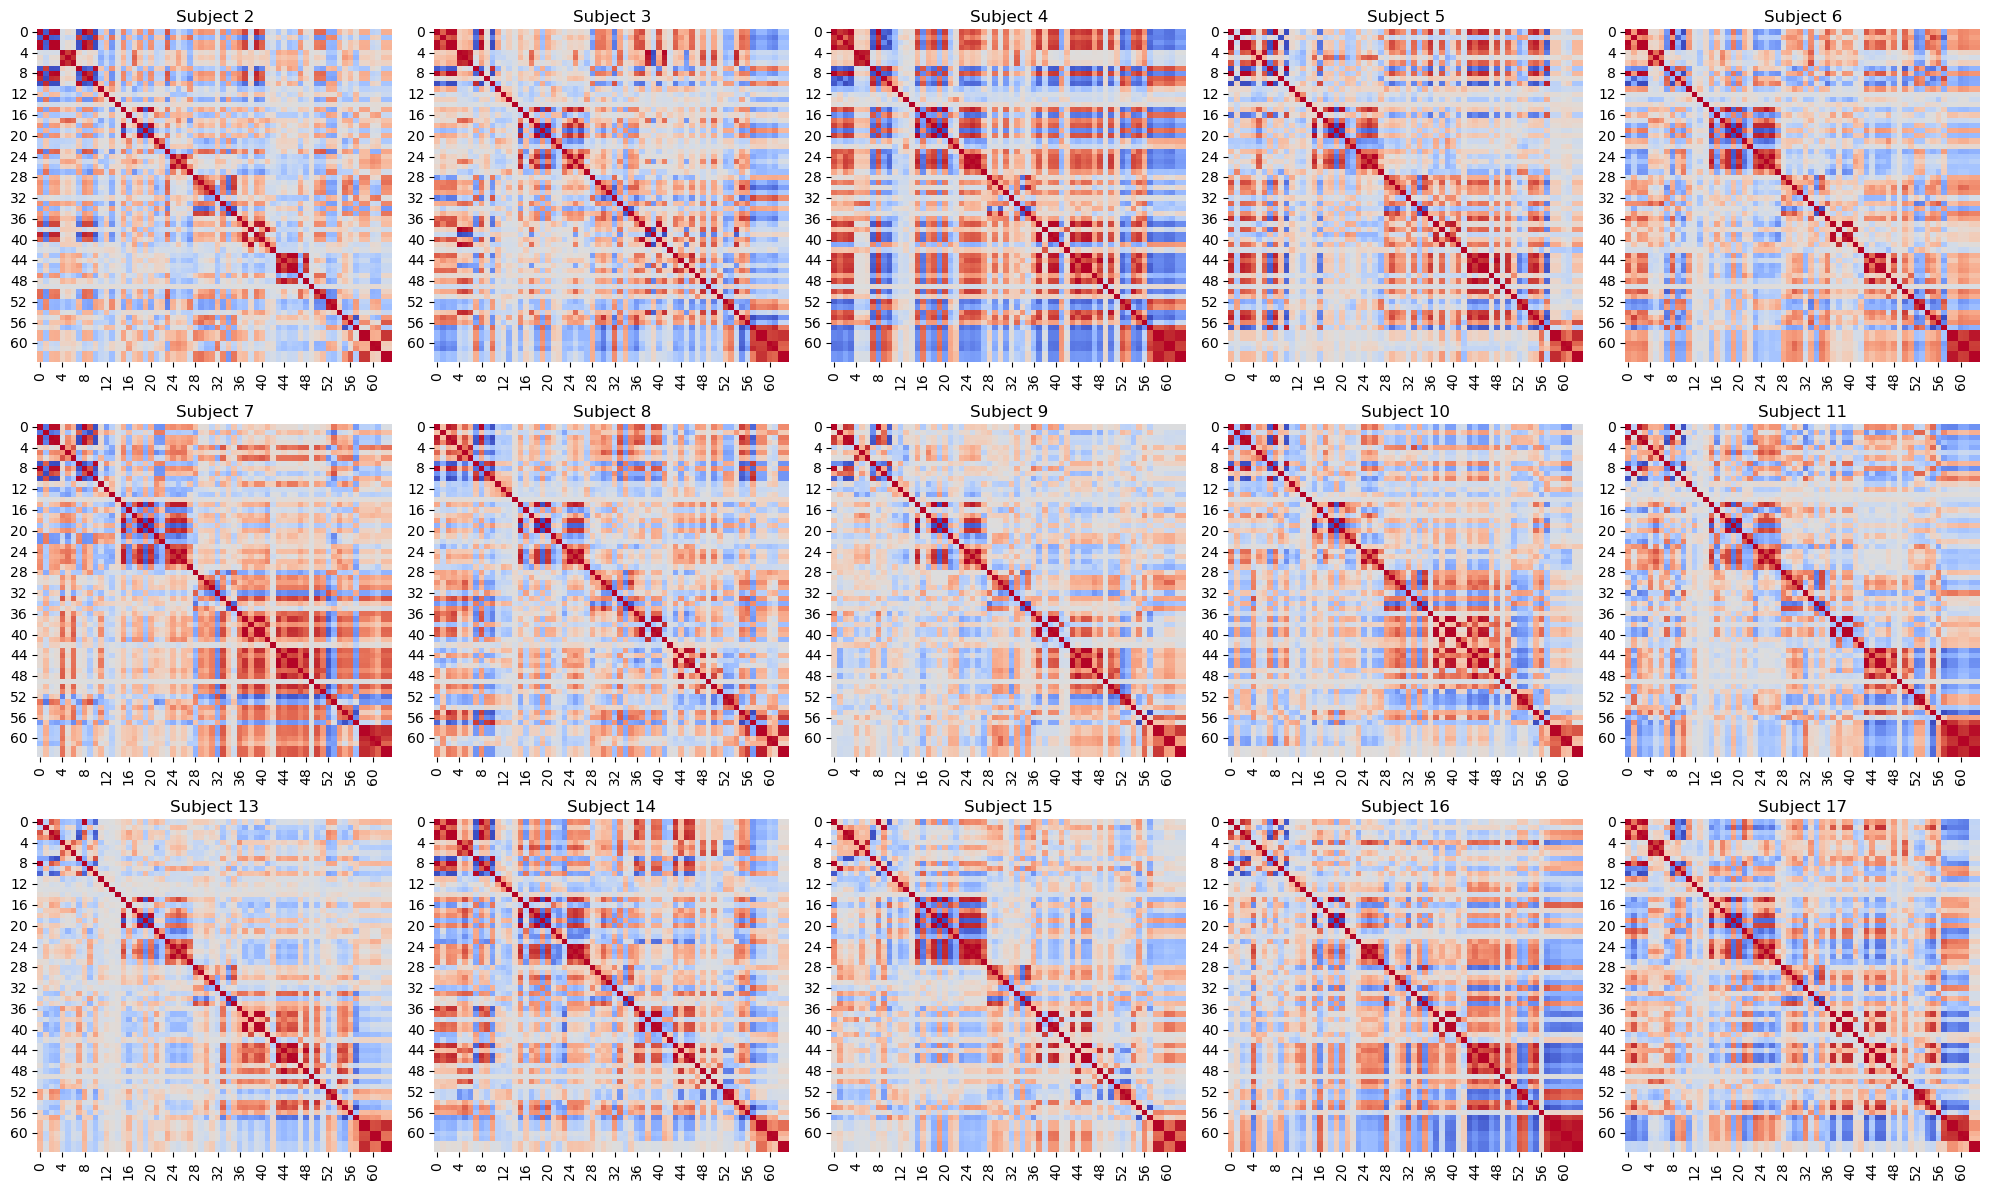

In [8]:
# Load data
file_path_zscored_by_sub = f"features/combined/feature_dict_zscored_by_sub.pkl"
feature_dict = load_dict_from_pickle(file_path_zscored_by_sub)

# Load features
feature_array = feature_dict['features']
feature_names = feature_dict['feature_names']
num_features = feature_array.shape[1]


## Plot feature correlation matrices across all subjects

# Calculate correlation matrix
corr_matrix = np.corrcoef(feature_array, rowvar=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation between features (all subjects)')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()


## Plot feature correlation matrices for each subject

# Preallocate correlation matrices
correlation_matrices = np.empty((NUM_SUBJECTS, num_features, num_features))

for i, sub in enumerate(SUBJECT_LIST):
    # Get features and calculate correlation matrices for each subject
    feats = feature_array[np.where(np.array(feature_dict['subject']) == sub)[0]]
    correlation_matrices[i] = np.corrcoef(feats, rowvar=False)

# Plot all of the correlation matrices
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, corr_matrix in enumerate(correlation_matrices):
    row = i // 5
    col = i % 5
    sns.heatmap(corr_matrix, ax=axs[row, col], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    axs[row, col].set_title(f'Subject {SUBJECT_LIST[i]}')

plt.tight_layout()
plt.show()

### Remove some features based on correlations and domain knowledge and do it again

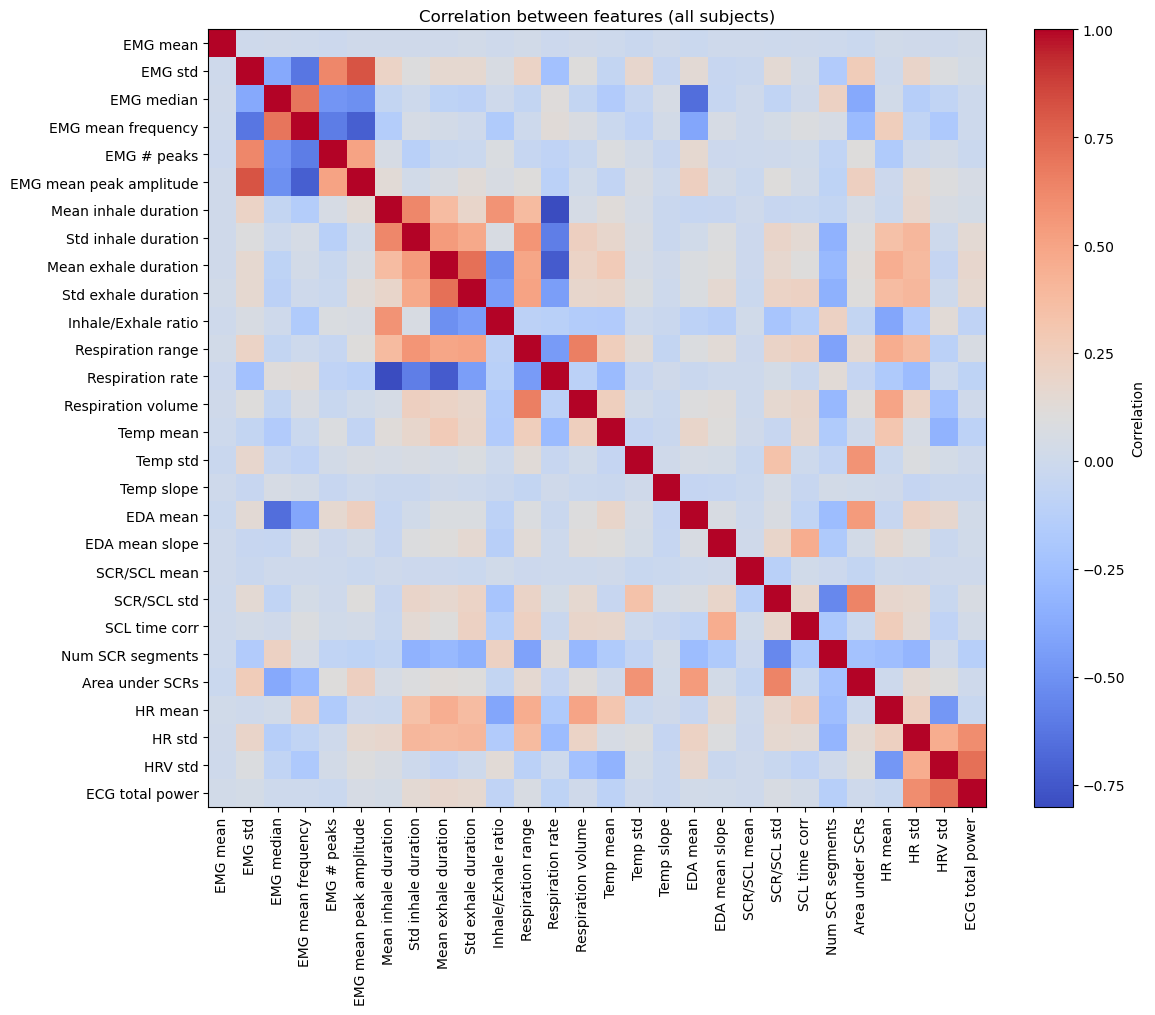

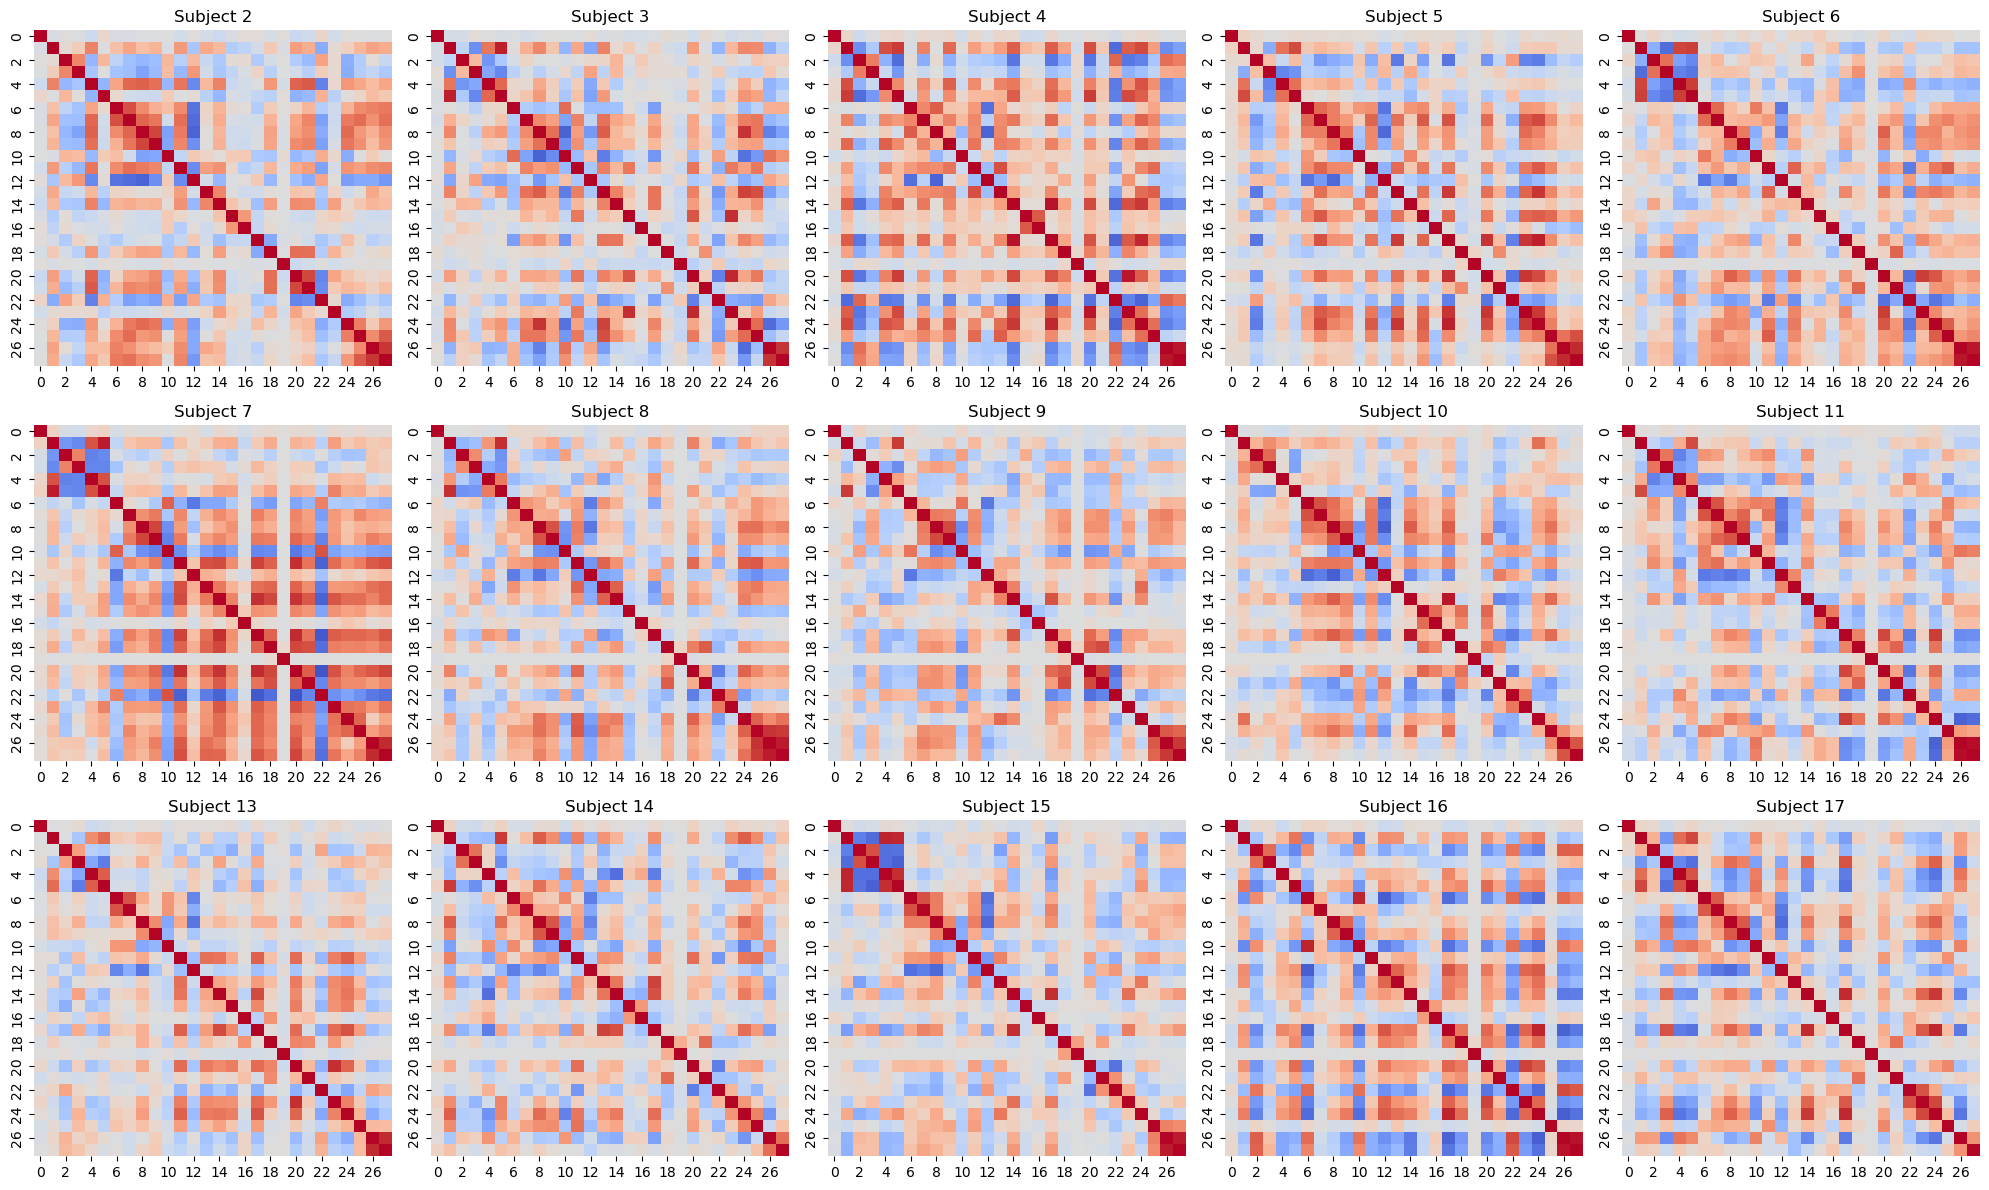

In [60]:
# Features to remove in the first pass based on domain knowledge and correlations.
features_to_remove_1 = ['ACC x mean', 'ACC y mean', 'ACC z mean', 'ACC mean', 'ACC x std', 'ACC y std',
                    'ACC z std', 'ACC std', 'ACC abs integral x', 'ACC abs integral y', 'ACC abs integral z',
                    'ACC peak frequency x', 'ACC peak frequency y', 'ACC peak frequency z', 
                    'EMG dynamic range', 'EMG absolute integral','EMG 10th percentile', 'EMG 90th percentile','EMG peak frequency', 'EMG std peak amplitude', 
                    'EMG sum peak amplitudes', 'EMG normalized sum peak amplitudes', 'Respiration duration',
                    'Temp min', 'Temp max', 'Temp dynamic range', 'EDA std', 'EDA min', 'EDA max', 'EDA dynamic range', 
                    'Sum of response durations', 'HRV mean', 'HRV RMS', 'nn50', 'pnn50', 'ECG HF energy']

# Remove features
reduced_feature_dict_1 = remove_features(feature_dict, features_to_remove_1)

# Load features
feature_array = reduced_feature_dict_1['features']
feature_names = reduced_feature_dict_1['feature_names']
num_features = feature_array.shape[1]


## Plot feature correlation matrices across all subjects

# Calculate correlation matrix
corr_matrix = np.corrcoef(feature_array, rowvar=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.title('Correlation between features (all subjects)')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
plt.tight_layout()
plt.show()


## Plot feature correlation matrices for each subject

# Preallocate correlation matrices
correlation_matrices = np.empty((NUM_SUBJECTS, num_features, num_features))

for i, sub in enumerate(SUBJECT_LIST):
    # Get features and calculate correlation matrices for each subject
    feats = feature_array[np.where(np.array(feature_dict['subject']) == sub)[0]]
    correlation_matrices[i] = np.corrcoef(feats, rowvar=False)

# Plot all of the correlation matrices
fig, axs = plt.subplots(3, 5, figsize=(20, 12))
for i, corr_matrix in enumerate(correlation_matrices):
    row = i // 5
    col = i % 5
    sns.heatmap(corr_matrix, ax=axs[row, col], cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
    axs[row, col].set_title(f'Subject {SUBJECT_LIST[i]}')

plt.tight_layout()
plt.show()

In [9]:
def train_test_split_LOOCV(feature_dict, test_subject):
    '''
    Given the feature dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']
    train_indices = np.where(np.array(feature_dict['subject']) != test_subject)[0]
    test_indices = np.where(np.array(feature_dict['subject']) == test_subject)[0]
    
    # Yell at is if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]

def train_test_split_LOOCV_binary(feature_dict, test_subject):
    '''
    Given the feature dict containing features for all of the subjects, 
    and the subject to leave out (test_subject), splits the data 
    into train and test data for Leave One Out Cross-Validation (LOOCV).
    
    Remove the amusement condition (no labels == 3) to make this a binary classification problem.
    
    Returns:
    X_train, X_test, y_train, y_test (train data, test data, train labels, test labels)
    '''
    
    features = feature_dict['features']
    labels = feature_dict['labels']

    train_indices = np.where((np.array(feature_dict['subject']) != test_subject) & (labels != 3))[0]
    test_indices = np.where((np.array(feature_dict['subject']) == test_subject) & (labels != 3))[0]
    
    # Yell at is if there is any overlap, just in case
    if np.any(np.isin(train_indices, test_indices)):
        print("NO! Train and test overlap!!!!!!")
        
    return features[train_indices], features[test_indices], labels[train_indices], labels[test_indices]


[[65740.  1104.]
 [ 1589. 34675.]]
Accuracy =  0.9729940221169286  Std:  0.06744000181731047
F1 =  0.979243606121151  Std:  0.05236917302947718
Coefs =  [-2.84908534e+01  1.12421647e+00  3.37403361e+00 -3.69314826e+00
  2.50945334e+00 -3.13533347e-01 -2.75652196e+00 -1.82472279e+00
  3.22007823e+01 -6.71262514e-01  2.82666814e+00  4.99916954e-03
  1.27347409e+00 -4.05162181e-01 -2.42087910e-01  6.02883457e+00
 -8.02968597e-01 -2.87800358e+00 -1.85318788e+01 -2.16061046e+00
  1.24336044e+01  1.76548153e+00 -1.14744208e+00 -1.63557693e+00
 -3.01823890e+01  6.13873263e-01  3.05167852e+01 -2.19165415e+00
 -9.28948623e-01  3.14411991e+00 -6.63357673e-01 -1.41769627e+00
 -4.09135715e+00 -1.15134591e-01  8.95993190e-01  3.10063990e+00
  2.89362352e-01  3.84173144e+00  1.22945576e-01  3.94482679e+00
 -2.94390367e+00  3.02027009e-01  4.92004686e-01  3.43234363e+00
 -9.53970542e-01 -8.89909378e-01  4.02575728e+00  1.46931855e+00
 -5.79718445e-01 -2.59598039e-01  4.96624879e-01 -7.47180144e-01
 -

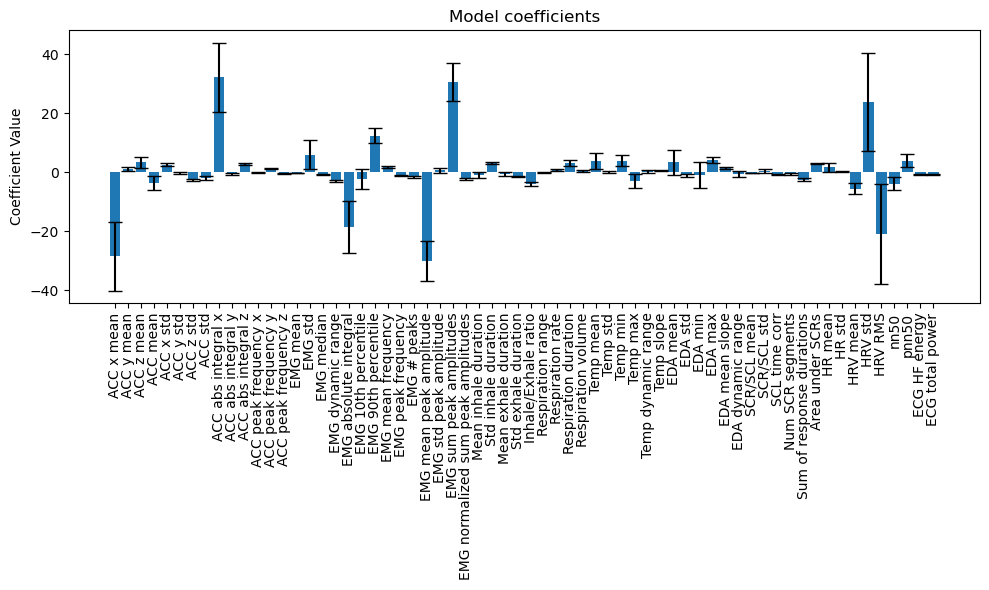

In [10]:
# Train 15 LDA models, leaving one subject out each time
num_features = len(feature_dict['feature_names'])

accuracies = np.zeros(len(SUBJECT_LIST))
f1_scores = np.zeros(len(SUBJECT_LIST))
coefs = np.zeros((len(SUBJECT_LIST), num_features))
confusion_matrices = np.zeros((len(SUBJECT_LIST), 2, 2)) 

for i, test_sub in enumerate(SUBJECT_LIST):
    
    # Split the data into training and testing sets by subject
    X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
    # Fit the model
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracies[i] = accuracy_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)
    coefs[i] = model.coef_
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)

combined_confusion_matrix = np.sum(confusion_matrices, axis=0)
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)
mean_coefs = np.mean(coefs, axis=0)
std_coefs = np.std(coefs, axis=0)

print(combined_confusion_matrix)
print("Accuracy = ", mean_acc, " Std: ", std_acc)
print("F1 = ", mean_f1, " Std: ", std_f1)
print("Coefs = ", mean_coefs)
print("Std coefs = ", std_coefs)

# Bar graph of coef magnitudes
x = np.arange(num_features)
plt.figure(figsize=(10, 6))
plt.bar(x, mean_coefs, yerr=std_coefs, capsize=5)
#plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Model coefficients')
plt.xticks(x, feature_dict['feature_names'],rotation='vertical')
#plt.ylim(-4000, 6500)
plt.tight_layout() 
#plt.savefig('3class_coefs_base.png')
plt.show()

In [59]:
# Train 15 QDA models, leaving one subject out each time
feature_dict = reduced_feature_dict_1

accuracies = np.zeros(len(SUBJECT_LIST))
f1_scores = np.zeros(len(SUBJECT_LIST))
confusion_matrices = np.zeros((len(SUBJECT_LIST), 2, 2)) 

for i, test_sub in enumerate(SUBJECT_LIST):
    
    # Split the data into training and testing sets by subject
    X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)
    
    # Fit the model
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracies[i] = accuracy_score(y_test, y_pred)
    f1_scores[i] = f1_score(y_test, y_pred)
    confusion_matrices[i] = confusion_matrix(y_test, y_pred)

combined_confusion_matrix = np.sum(confusion_matrices, axis=0)
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)
mean_f1 = np.mean(f1_scores)
std_f1 = np.std(f1_scores)

print(combined_confusion_matrix)
print("Accuracy = ", mean_acc, " Std: ", std_acc)
print("F1 = ", mean_f1, " Std: ", std_f1)

/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variab

[[59472.  7372.]
 [ 3091. 33173.]]
Accuracy =  0.8982530956484926  Std:  0.0844805276958375
F1 =  0.9155868187547896  Std:  0.07308439609033768


/Users/steph/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Training ... 


  0%|          | 0/500 [00:00<?, ?it/s]

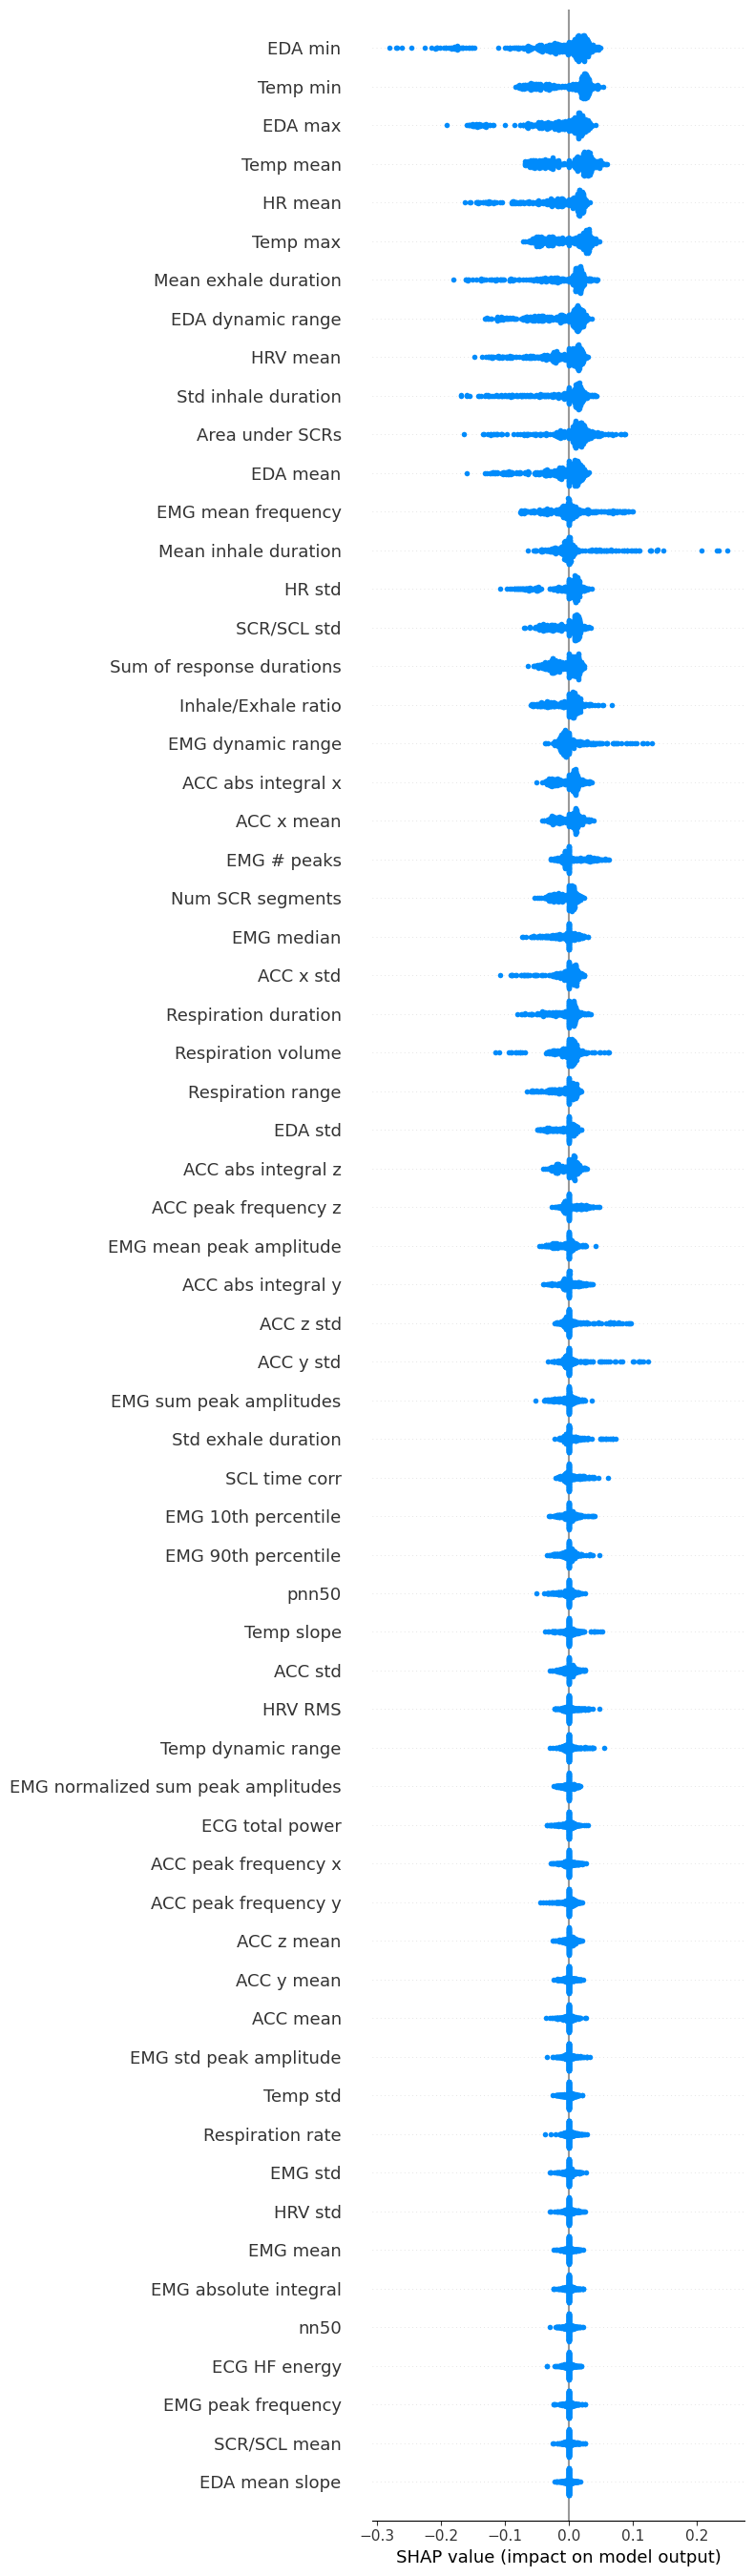

100%|███████████████████████████████████████████| 10/10 [00:47<00:00,  4.76s/it]


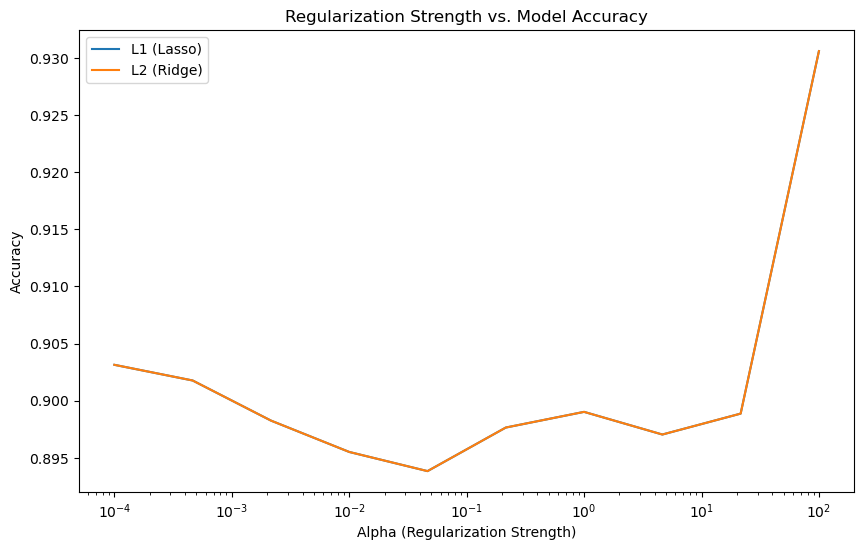

In [11]:
import numpy as np
import shap
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

test_sub = 2
feature_names = feature_dict['feature_names']

# Split the data into training and testing sets by subject
X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)

# Create a neural network model
model = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', random_state=42)

# Train the model
print("Training ... ")
model.fit(X_train, y_train)

# Create background samples
background = shap.sample(X_train, 100)  # Use 100 background samples

# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict_proba, background)

# Calculate SHAP values - randomly select 500 samples from X_test (its too slow to use the whole thing)
random_samples = np.random.randint(0, X_test.shape[0], size=500)
shap_values = explainer.shap_values(X_test[random_samples, :])

# Plot SHAP summary plot
shap.summary_plot(shap_values[:,:,0], feature_names=feature_names, max_display=len(feature_names))

# Investigate L1 and L2 regularization
alphas = np.logspace(-4, 2, 10)
l1_scores = []
l2_scores = []

for alpha in tqdm(alphas):
    # L1 regularization (Lasso)
    model_l1 = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', alpha=alpha, random_state=42)
    model_l1.fit(X_train, y_train)
    l1_scores.append(model_l1.score(X_test, y_test))
    
    # L2 regularization (Ridge)
    model_l2 = MLPClassifier(hidden_layer_sizes=(32,), activation='relu', solver='adam', alpha=alpha, random_state=42)
    model_l2.fit(X_train, y_train)
    l2_scores.append(model_l2.score(X_test, y_test))

# Plot regularization strength vs. accuracy
plt.figure(figsize=(10, 6))
plt.plot(alphas, l1_scores, label='L1 (Lasso)')
plt.plot(alphas, l2_scores, label='L2 (Ridge)')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Regularization Strength vs. Model Accuracy')
plt.legend()
plt.show()

(500, 29, 2)
(500, 29)


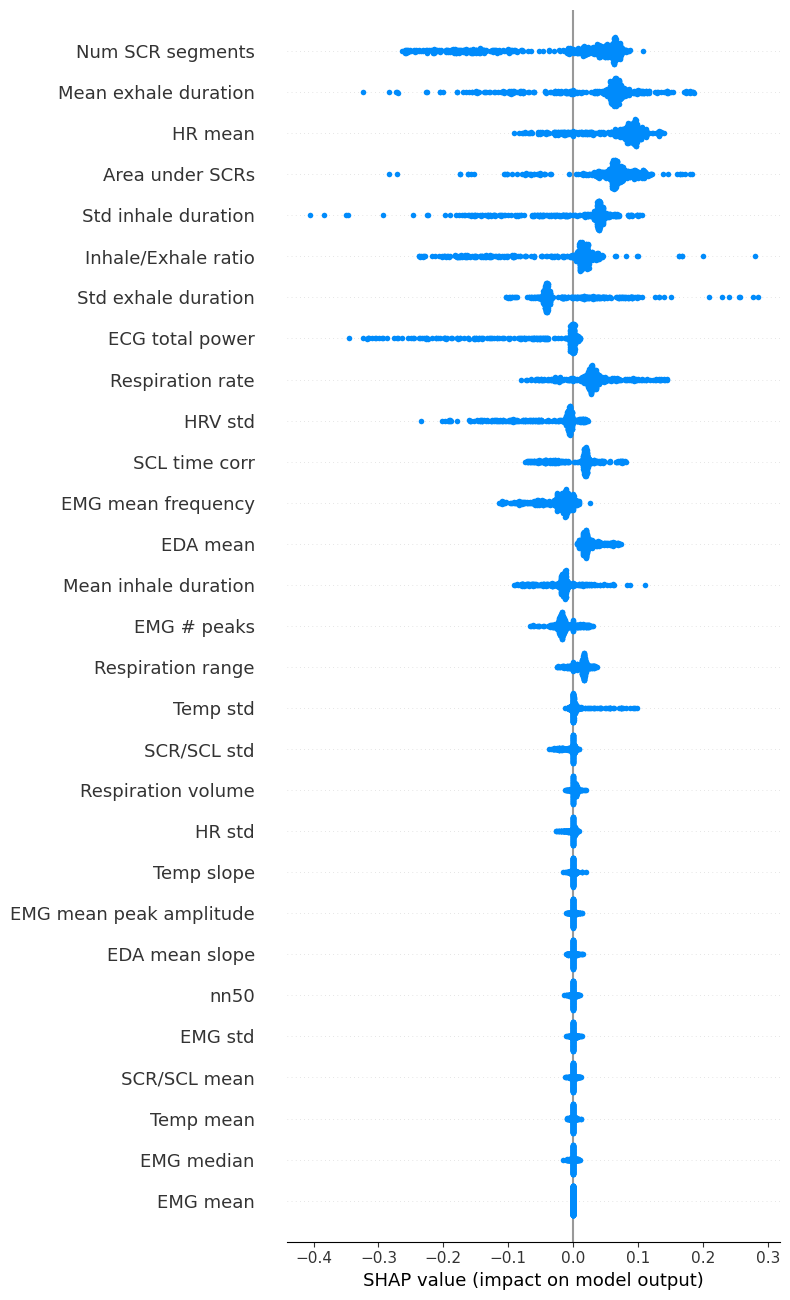

In [71]:
# Plot SHAP summary plot
print(shap_values.shape)
print(shap_values[:,:,0].shape)
shap.summary_plot(shap_values[:,:,0], feature_names=feature_names, max_display=29)

In [ ]:
import numpy as np
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import shap
from sklearn.model_selection import train_test_split

test_sub = 2

# Split the data into training and testing sets by subject
X_train, X_test, y_train, y_test = train_test_split_LOOCV_binary(feature_dict, test_sub)

# Define a simple neural network architecture
model = Sequential([
    Dense(8, input_shape=(10,), activation='relu'),  # Input layer with 8 neurons and ReLU activation
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Calculate SHAP values
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Visualize SHAP values (example for the first sample)
shap.summary_plot(shap_values, X_test)

# Apply L1 regularization
l1_model = Sequential([
    Dense(32, input_shape=(10,), activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    Dense(1, activation='sigmoid')
])
l1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
l1_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Inspect learned coefficients (example for the first layer)
print("Learned Coefficients (L1 Regularization):")
print(l1_model.layers[0].get_weights()[0])

# Apply L2 regularization
l2_model = Sequential([
    Dense(32, input_shape=(10,), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1, activation='sigmoid')
])
l2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
l2_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

# Inspect learned coefficients (example for the first layer)
print("Learned Coefficients (L2 Regularization):")
print(l2_model.layers[0].get_weights()[0])